# Analyze the Survey Data

Analyze the survey data in `survey.csv` using the power of PYTHON!!

Also STATISTICS!!

And maybe some other made up stuff

## Installing

In a clean `python3` environment, run:

In [1]:
!pip install -r requirements.txt

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Imports and etc

In [2]:
# Standard Lib
import itertools

# 3rd party
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ttest_ind


## Loading the Raw Data

Load the data

In [3]:
df = pd.read_csv("survey.csv")

In [4]:
df.head()

,Timestamp,Gender identity?,What is your sexual identity?,What is your age?,What is the age range you are willing to date a member of your preferred sex (MPS)? (Check all that apply),What is the age range you would PREFER/WANT to date?,"For each of the age ranges you checked off that you would PREFER to date, please provide a short reason why you would date that age range"
0,2019/07/15 2:38:18 PM AST,Male,Heterosexual,26-29,3-5 years younger;Same age to 2 years younger;...,Same age to 2 years younger,Similar maturity.
1,2019/07/15 2:40:10 PM AST,Male,Heterosexual,30+,5-10 years younger;3-5 years younger;Same age ...,5-10 years younger;3-5 years younger;Same age ...,"kids, maturity level is more similar to mine"
2,2019/07/15 2:42:02 PM AST,Male,Heterosexual,30+,10+ years younger;5-10 years younger;3-5 years...,10+ years younger;5-10 years younger;3-5 years...,"10+ younger- Sugarbaby/eyecandy, 5-10 younger ..."
3,2019/07/15 2:49:03 PM AST,Female,Heterosexual,23-25,Same age to 2 years younger;3 years older to s...,3 years older to same old,Like to taken care off lol
4,2019/07/15 2:54:49 PM AST,Male,Heterosexual,30+,5-10 years younger;3-5 years younger;Same age ...,Same age to 2 years younger;3 years older to s...,For females that are the same age to 2 years y...


## Data cleaning and normalization

Alias categories for easier plotting

In [5]:
df['gender'] = df['Gender identity?']
df['identity'] = df['What is your sexual identity?']
df['age'] = df['What is your age?']
df['willing_to_date'] = df['What is the age range you are willing to date a member of your preferred sex (MPS)? (Check all that apply)']
df['prefer_to_date'] = df['What is the age range you would PREFER/WANT to date?']
df['reason'] = df['For each of the age ranges you checked off that you would PREFER to date, please provide a short reason why you would date that age range']

df = df[['gender', 'identity', 'age', 'willing_to_date', 'prefer_to_date', 'reason']]

In [6]:
df.head()

,gender,identity,age,willing_to_date,prefer_to_date,reason
0,Male,Heterosexual,26-29,3-5 years younger;Same age to 2 years younger;...,Same age to 2 years younger,Similar maturity.
1,Male,Heterosexual,30+,5-10 years younger;3-5 years younger;Same age ...,5-10 years younger;3-5 years younger;Same age ...,"kids, maturity level is more similar to mine"
2,Male,Heterosexual,30+,10+ years younger;5-10 years younger;3-5 years...,10+ years younger;5-10 years younger;3-5 years...,"10+ younger- Sugarbaby/eyecandy, 5-10 younger ..."
3,Female,Heterosexual,23-25,Same age to 2 years younger;3 years older to s...,3 years older to same old,Like to taken care off lol
4,Male,Heterosexual,30+,5-10 years younger;3-5 years younger;Same age ...,Same age to 2 years younger;3 years older to s...,For females that are the same age to 2 years y...


## Parameters that really mess with the analysis

These are the parameters that really shape how the analysis works



In [7]:
# The maximum value that people meant by selecting "30+ years old"
max_age = 50  # in years - Maximum age in the survey

# The minimum value that people meant by selecting "10+ years younger"
max_younger = -30  # in years - Minimum age difference in the survey

# The maximum value that people meant by selecting "10+ years younger"
max_older = 30  # in years - Maximum age difference in the survey

Encode the category ranges to numeric values for ease of analysis

In [8]:
# Map the long category names to numeric values
preferred_date_map = {
    '10+ years older': (10, max_older),
    '10+ years younger': (max_younger, -10),
    '3 years older to same age': (0, 3),
    '3 years older to same old': (0, 3),
    '3-5 years younger': (-5, -3),
    '3-6 years older': (3, 6),
    '5-10 years younger': (-10, -5),
    '7-10 years older': (7, 10),
    'Same age to 2 years younger': (-2, 0),
}

def encode_ranges(cat: str) -> tuple:
    """ Encode the range checkboxes into a bounding range """
    if cat in (None, np.nan):
        return pd.Series({'min': np.nan, 'mean': np.nan, 'max': np.nan})
    ranges = np.array([preferred_date_map[c] for c in cat.split(';') if c in preferred_date_map])
    min_range = np.min(ranges)
    max_range = np.max(ranges)
    mean_range = np.mean([min_range, max_range])
    
    return pd.Series({'min': min_range, 'mean': mean_range, 'max': max_range})
    

# Encode the checkboxes into ranges
willing_range = df['willing_to_date'].apply(encode_ranges)
df['min_willing'] = willing_range['min']
df['mean_willing'] = willing_range['mean']
df['max_willing'] = willing_range['max']

prefer_range = df['prefer_to_date'].apply(encode_ranges)
df['min_prefer'] = prefer_range['min']
df['mean_prefer'] = prefer_range['mean']
df['max_prefer'] = prefer_range['max']

# Encode the ages into ranges
# Label to min, mean, max
age_map = {
    '18-22': (18, 20, 22),
    '23-25': (23, 24, 25),
    '26-29': (26, 27.5, 29),
    '30+': (30, 40, max_age),
}
age_map = {k: pd.Series({'min': v0, 'mean': v1, 'max': v2})
           for k, (v0, v1, v2) in age_map.items()}
age_range = df['age'].apply(lambda x: age_map[x])
df['min_age'] = age_range['min']
df['mean_age'] = age_range['mean']
df['max_age'] = age_range['max']

# Drop the unused columns again
df = df[['gender', 'identity',
         'age', 'min_age', 'mean_age', 'max_age',
         'min_willing', 'mean_willing', 'max_willing',
         'min_prefer', 'mean_prefer', 'max_prefer',
         'reason']]


In [9]:
# Get some weird NA columns, so just drop them
print('Before dropping invalid values: {}'.format(df.shape))
df = df.dropna(axis=0, how='any')
print('After dropping invalid values: {}'.format(df.shape))
df.head()

Before dropping invalid values: (83, 13)
After dropping invalid values: (82, 13)


,gender,identity,age,min_age,mean_age,max_age,min_willing,mean_willing,max_willing,min_prefer,mean_prefer,max_prefer,reason
0,Male,Heterosexual,26-29,26.0,27.5,29.0,-5.0,-1.0,3.0,-2.0,-1.0,0.0,Similar maturity.
1,Male,Heterosexual,30+,30.0,40.0,50.0,-10.0,-5.0,0.0,-10.0,-5.0,0.0,"kids, maturity level is more similar to mine"
2,Male,Heterosexual,30+,30.0,40.0,50.0,-30.0,0.0,30.0,-30.0,0.0,30.0,"10+ younger- Sugarbaby/eyecandy, 5-10 younger ..."
3,Female,Heterosexual,23-25,23.0,24.0,25.0,-2.0,0.5,3.0,0.0,1.5,3.0,Like to taken care off lol
4,Male,Heterosexual,30+,30.0,40.0,50.0,-10.0,-2.0,6.0,-2.0,0.5,3.0,For females that are the same age to 2 years y...


## Demographic distributions

The survey actually looks relatively balanced for gender identity considering how biased the sampling was...


(of course than `Other` which would require more sophisticated methodology)

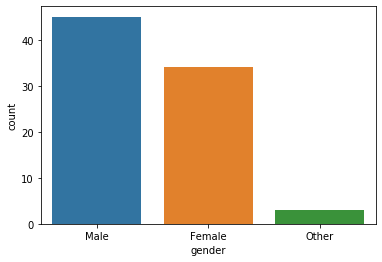

In [10]:
sns.countplot(data=df, x='gender');

It's fairly unbalanced for sexual identity, but that was always going to be hard with a random friend sample...

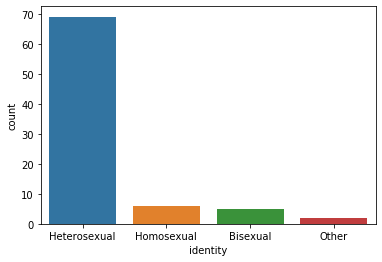

In [11]:
sns.countplot(data=df, x='identity');

And we have a nice bell curve for age...

Excercise left to the reader: *If you are 27 years old, do the ages of your friends follow a normal distribution?*

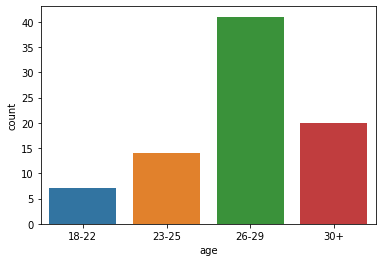

In [12]:
sns.countplot(data=df, x='age', order=['18-22', '23-25', '26-29', '30+']);

## Basic Results

And the moment everyone was waiting for: THE DISTRIBUTION OF PREFERENCES!!!

(with boundaries provided by https://www.explainxkcd.com/wiki/index.php/314:_Dating_Pools)

### Willing to Date

First, what ranges are people **WILLING** to date

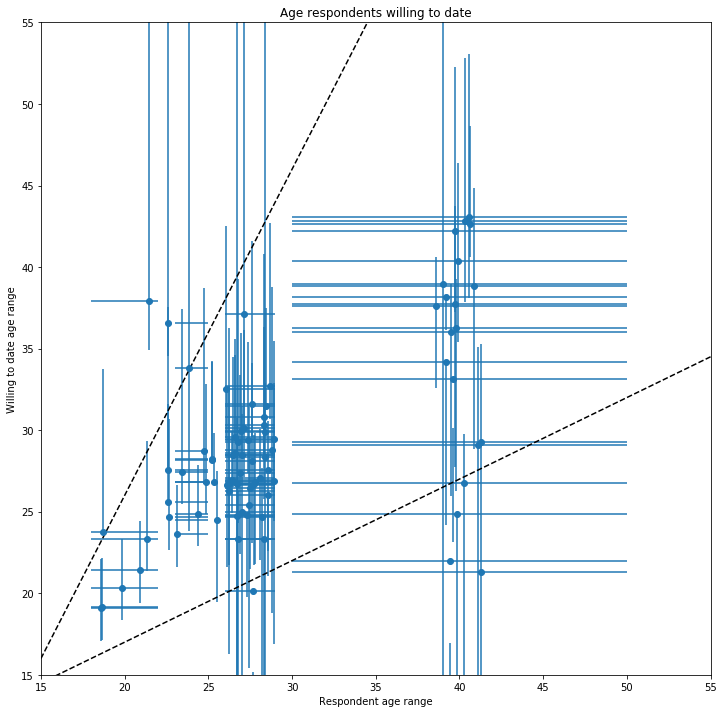

In [13]:
# Work out the xkcd boundaries
x_age = np.linspace(15, 55, 100)
y_lower = x_age/2.0 + 7.0
y_upper = (x_age - 7.0)*2.0

# Plot the survey responses on a scatter
x = df['mean_age'] + (np.random.rand(df.shape[0], ) - 0.5)*3  # With some jitter to see the points
xerr = (x-df['min_age'], df['max_age']-x)

y = df['mean_willing'] + x
yerr = (np.abs(df['min_willing']), df['max_willing'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
ax.plot(x_age, y_lower, '--k')
ax.plot(x_age, y_upper, '--k')
ax.set_xlim([15, 55])
ax.set_ylim([15, 55])
ax.set_xlabel('Respondent age range')
ax.set_ylabel('Willing to date age range')
ax.set_title('Age respondents willing to date');

So in terms of willing to date, it looks like the *half your age plus seven* rule is:

1. Too young when you're in the 18-25 bin (this group is willing to date partners their own age or older)
2. Basically correct in the 26-29 bin (this group is only willing to date a partner within the age that the rule predicts)
3. Too old when you're in the 30+ bin (this group is willing to date partners their own age or younger)

The 30+ group is hard to call, because it's sensitive to where I set the outer bound. For instance, if everyone who checked 30+ is under 35 (the analysis assumes under 50), we still skew younger, but maybe don't violate the lower bound quite so much.

Similarly, a lot of the variation is driven by what more than 10 years younger (I assume 10 to 30 years younger, which in some cases gets icky to think about), and what more than 10 years older (again 10 to 30 years older) means. If you move those ranges around, you get different answers

### Prefer to Date

What ranges do people claim that they would **PREFER** to date

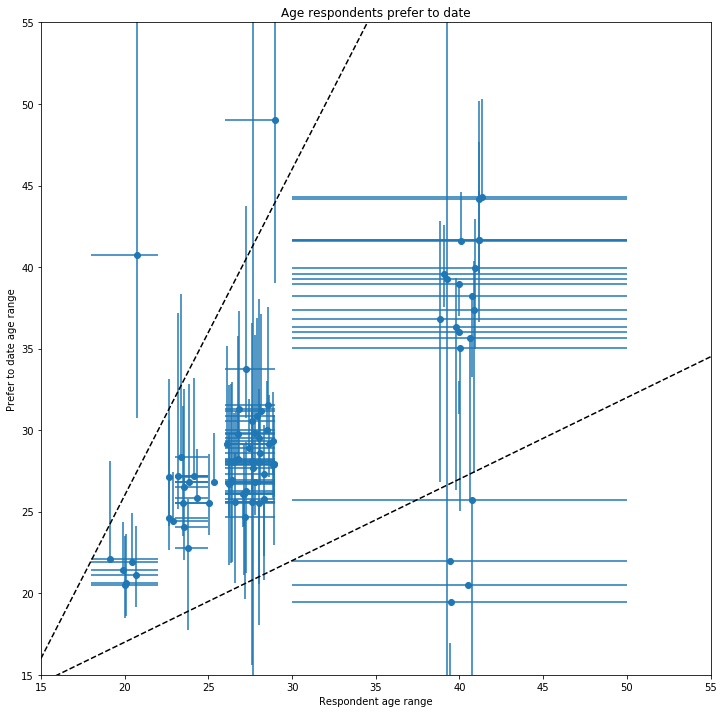

In [14]:
# Plot the survey responses on a scatter
x = df['mean_age'] + (np.random.rand(df.shape[0], ) - 0.5)*3  # With some jitter to see the points
xerr = (x-df['min_age'], df['max_age']-x)

y = df['mean_prefer'] + x
yerr = (np.abs(df['min_prefer']), df['max_prefer'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
ax.plot(x_age, y_lower, '--k')
ax.plot(x_age, y_upper, '--k')
ax.set_xlim([15, 55])
ax.set_ylim([15, 55])
ax.set_xlabel('Respondent age range')
ax.set_ylabel('Prefer to date age range')
ax.set_title('Age respondents prefer to date');

The trends around preference are similar:

1. 18-25 year olds prefer their own age or a bit older
2. 26-29 year olds prefer their own age (or maybe a little younger)
3. 30+ prefer a partner their own age or younger

Same caveats about ranges on the +/- boundaries. You have to make an assumption to draw the plots, but those assumptions impact the results

## Yeah, sure, but can you do stats at it?

You bet your boots we can!

### Gender Identity

Is there a difference based on gender identity?

Willing P-value: 0.0012
Prefer P-value: 0.0366


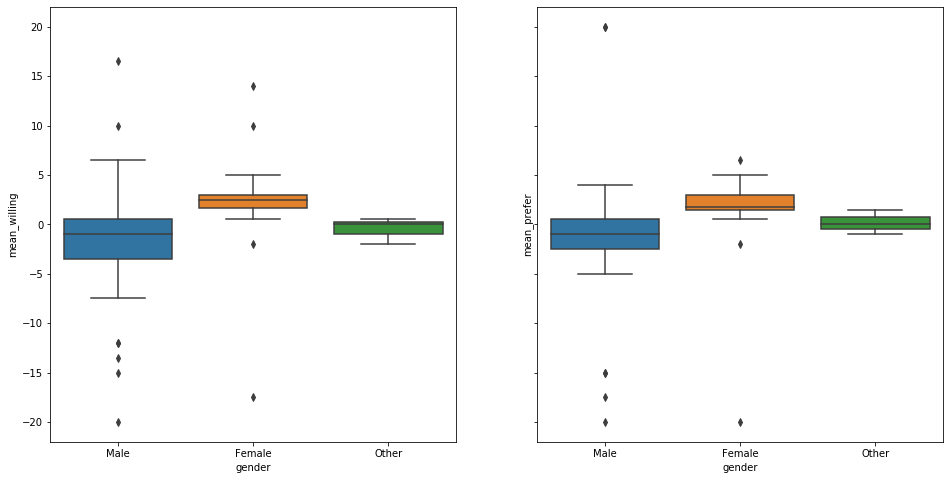

In [15]:
# Split up the data by group
values_willing = {}
values_prefer = {}
for group in np.unique(df['gender']):
    mask = df['gender'] == group
    
    values_willing[group] = df['mean_willing'].values[mask]
    values_prefer[group] = df['mean_prefer'].values[mask]

print('Willing P-value: {:0.4f}'.format(ttest_ind(values_willing['Male'], values_willing['Female'])[1]))
print('Prefer P-value: {:0.4f}'.format(ttest_ind(values_prefer['Male'], values_prefer['Female'])[1]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
sns.boxplot(ax=ax1, data=df, x='gender', y='mean_willing')
sns.boxplot(ax=ax2, data=df, x='gender', y='mean_prefer');

So respondents who identify as male vs female have very significant differences in the mean age they are **WILLING** to date, and weaker, but still significant differences in the mean age they **PREFER** to date. Specifically, males appear to prefer a slightly younger partner, and females prefer a slightly older partner.

Unfortunately, we don't have enough people who identify as other (n=3) in the survey to run the T-test, but they appear to have a neutral or very slightly younger trend to their preferences.

(Also, for people who don't believe in T-tests, the Mann Whitney U-test is slightly more significant, although again we only have enough samples to run male vs female):

In [16]:
print('Willing P-value: {:0.10f}'.format(mannwhitneyu(values_willing['Male'],
                                                      values_willing['Female'])[1]))
print('Prefer P-value: {:0.10f}'.format(mannwhitneyu(values_prefer['Male'],
                                                     values_prefer['Female'])[1]))

Willing P-value: 0.0000000985
Prefer P-value: 0.0000000990


### Sexual Identity

How about sexual identity?

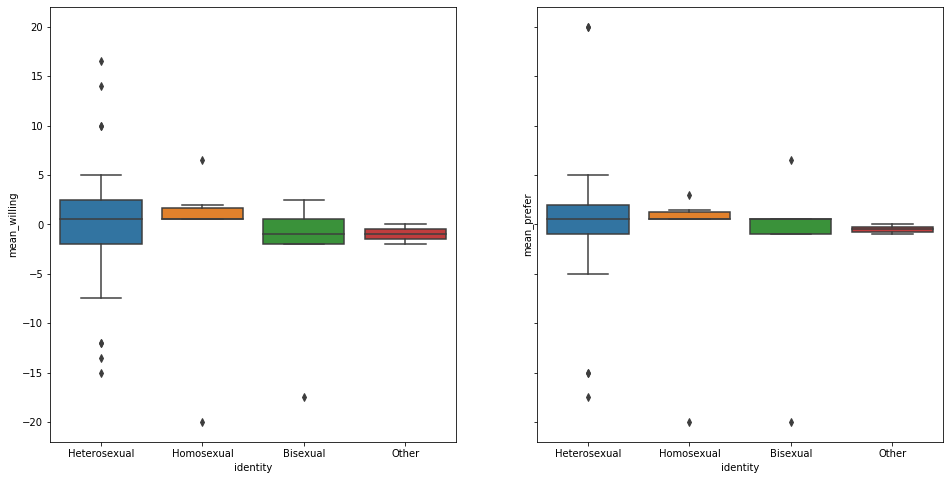

In [17]:
# Plot by sexual identity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
sns.boxplot(ax=ax1, data=df, x='identity', y='mean_willing')
sns.boxplot(ax=ax2, data=df, x='identity', y='mean_prefer');

We don't really have enough samples in the non-Heterosexual groups to dig into these trends, but what if we collapse the groups into Heterosexual and LGBTQ+?

Willing P-value: 0.1364
Prefer P-value: 0.1483


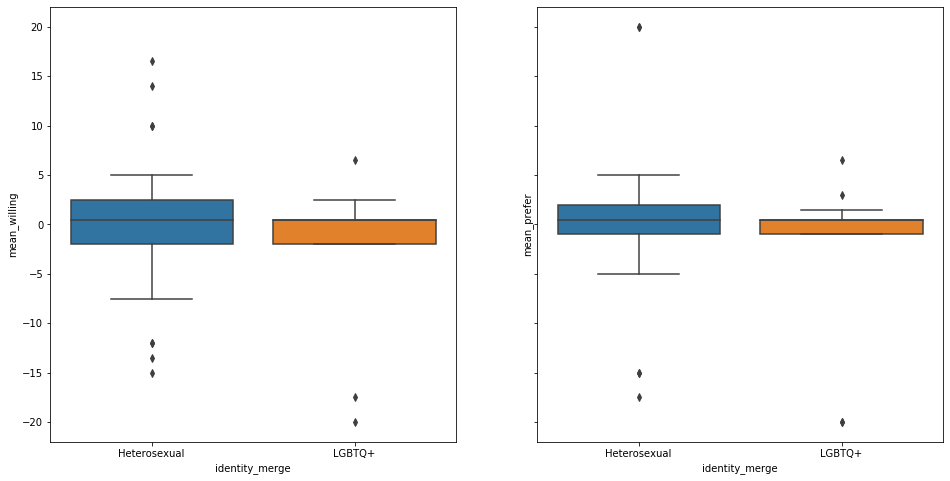

In [18]:
df['identity_merge'] = df['identity'].map({'Heterosexual': 'Heterosexual',
                                           'Homosexual': 'LGBTQ+',
                                           'Bisexual': 'LGBTQ+',
                                           'Other': 'LGBTQ+'})

# Split up the data by group
values_willing = {}
values_prefer = {}
for group in np.unique(df['identity_merge']):
    mask = df['identity_merge'] == group
    
    values_willing[group] = df['mean_willing'].values[mask]
    values_prefer[group] = df['mean_prefer'].values[mask]

print('Willing P-value: {:0.4f}'.format(ttest_ind(values_willing['Heterosexual'], values_willing['LGBTQ+'])[1]))
print('Prefer P-value: {:0.4f}'.format(ttest_ind(values_prefer['Heterosexual'], values_prefer['LGBTQ+'])[1]))

# Plot by sexual identity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
sns.boxplot(ax=ax1, data=df, x='identity_merge', y='mean_willing')
sns.boxplot(ax=ax2, data=df, x='identity_merge', y='mean_prefer');


Looks like not much difference. There's a slight trend towards the non-Heterosexual group preferring younger partners, but it's very much not significantly different.

### Age Group

Finally, did those trends we made wild claims about earlier hold up in the age data?

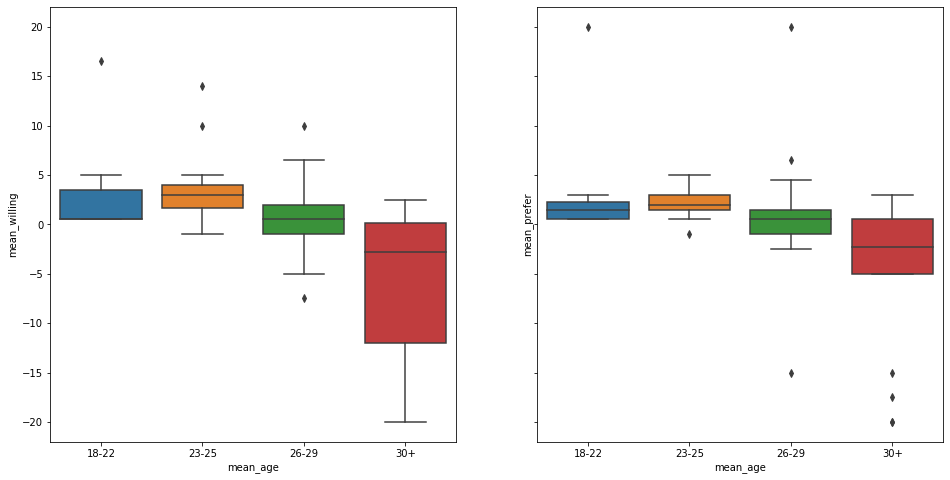

In [19]:
# Plot by sexual identity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
sns.boxplot(ax=ax1, data=df, x='mean_age', y='mean_willing')
sns.boxplot(ax=ax2, data=df, x='mean_age', y='mean_prefer')

ax1.set_xticklabels(['18-22', '23-25', '26-29', '30+'])
ax2.set_xticklabels(['18-22', '23-25', '26-29', '30+']);

Let's just blindly do all the comparisons and see what happens (this is the proper way to do stats and definitely not a bad idea...)

In [20]:
# Split up the data by group
values_willing = {}
values_prefer = {}
for group in np.unique(df['age']):
    mask = df['age'] == group
    
    values_willing[group] = df['mean_willing'].values[mask]
    values_prefer[group] = df['mean_prefer'].values[mask]

# Blindly try every combination, with the power of itertools
num_comps = 6  # Correct for multiple comparisons with a brute force multiplier (Bonferroni correction)
for (group1, group2) in itertools.combinations(np.unique(df['age']), r=2):
    print('{} vs {}'.format(group1, group2))
    print('Willing P-value: {:0.4f}'.format(ttest_ind(values_willing[group1], values_willing[group2])[1]*num_comps))
    print('Prefer P-value: {:0.4f}'.format(ttest_ind(values_prefer[group1], values_prefer[group2])[1]*num_comps))
    print('')

18-22 vs 23-25
Willing P-value: 5.9217
Prefer P-value: 2.3621

18-22 vs 26-29
Willing P-value: 0.1991
Prefer P-value: 0.6719

18-22 vs 30+
Willing P-value: 0.0431
Prefer P-value: 0.0864

23-25 vs 26-29
Willing P-value: 0.0153
Prefer P-value: 1.3304

23-25 vs 30+
Willing P-value: 0.0012
Prefer P-value: 0.0126

26-29 vs 30+
Willing P-value: 0.0004
Prefer P-value: 0.0056



Neat, we can kind of see the trend we were making wild, hand-wavey claims about earlier:

1. 18-22 year olds and 23-25 year olds look very similar (they are willing to date, and prefer slightly older partners)
2. Somewhere between 25 and 29, respondents start to report a willingness to date younger partners
3. The 30+ group has a strong and distinct bias towards younger partners that survives even a very cheesy correction for multiple comparisons